# Example Notebook

This example Jupyter Notebook is designed to facilitate the process of loading data, setting up models, and running experiments for context-based question answering with `SelfElicit` and other baseline methods.
It also showcases how to use the utility functions provided in this repository to run experiments across different datasets and models.

You can change settings by modifying the `config.yaml` file.

## Main Modules Used in this Example

1. **args**:
    - **get_args**: Function to retrieve and set up arguments for the notebook.
  
2. **dataloader**:
    - **load_data**: Function to load datasets for the experiments.

3. **utils**:
    - **get_model_tokenizer_device**: Function to load the model, tokenizer, and device (e.g., GPU or CPU) for running the experiments.

4. **qa_agent**:
    - **get_agents_dict**: Function to prepare QA agent instances with different instructions.
    - **ContextQuestionAnsweringAgent**: Class for handling context-based question answering tasks.

5. **eval**:
    - **evaluate**: Function to evaluate the model's answers against the true answers using metrics like F1 score and Exact Match (EM).

6. **self_elicit**:
    - **get_answer_base**: Function to get the base answer from the model.
    - **get_answer_cot**: Function to get the answer using Chain-of-Thought (COT) reasoning.
    - **get_answer_fullelicit**: Function to get the answer using full elicitation.
    - **get_answer_promptelicit**: Function to get the answer using prompt elicitation.
    - **get_answer_selfelicit**: Function to get the answer using self-elicit method.

## Arguments (modifiable in `config.yaml`)

| Argument            | Description                                                                          | Default (Valid Options)                                                                                                                                                                                                                                                                                                                                                  |
| ------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `--hf_token`        | Hugging Face API token.                                                              | `"your_hf_api_token"` (Replace with your own token)                                                                                                                                                                                                                                                                                                                      |
| `--model_id`        | The HuggingFace Model ID. Should be one of the specified models.                     | `"meta-llama/Meta-Llama-3.1-8B-Instruct"` (`"meta-llama/Meta-Llama-3.1-70B-Instruct"`, `"mistralai/Mistral-7B-Instruct-v0.3"`, `"mistralai/Mistral-Nemo-Instruct-2407"`, `"Qwen/Qwen2.5-7B-Instruct"`, `"Qwen/Qwen2.5-32B-Instruct"`)                                                                                                                                    |
| `--methods`         | Method(s) to test. Can be a list or a single value.                                  | `["Base", "COT", "FullElicit", "PromptElicit", "SelfElicit"]`                                                                                                                                                                                                                                                                                                            |
| `--datasets`        | Dataset(s) to use. Can be a list or a single value.                                  | `["HotpotQA", "NewsQA", "TQA", "NQ"]`                                                                                                                                                                                                                                                                                                                                    |
| `--alpha`           | Threshold for the SelfElicit method.                                                 | 0.5                                                                                                                                                                                                                                                                                                                                                                      |
| `--layer_span`      | A tuple representing the layer span for the SelfElicit method.                       | `(0.5, 1.0)` (Must be a tuple of two floats between [0, 1])                                                                                                                                                                                                                                                                                                              |
| `--gpu_ids`         | List of GPU IDs to use for computation.                                              | `[0]` (Auto-detected if not specified)                                                                                                                                                                                                                                                                                                                                   |
| `--n_samples`       | Number of samples in each dataset.                                                   | 1000 (Set to `None` to use the full data)                                                                                                                                                                                                                                                                                                                                |
| `--random_state`    | The random state for reproducibility.                                                | 0                                                                                                                                                                                                                                                                                                                                                                        |
| `--max_ans_tokens`  | Maximum length of the answer in tokens.                                              | 100                                                                                                                                                                                                                                                                                                                                                                      |
| `--marker_impstart` | Marker indicating the start of important information in the context.                 | `"<START_IMPORTANT>"`                                                                                                                                                                                                                                                                                                                                                    |
| `--marker_impend`   | Marker indicating the end of important information in the context.                   | `"<END_IMPORTANT>"`                                                                                                                                                                                                                                                                                                                                                      |
| `--qa_inst`         | Instruction for context-based QA.                                                    | "Directly answer the question based on the context passage, no explanation is needed. If the context does not contain any evidence, output 'I cannot answer based on the given context.'"                                                                                                                                                                                |
| `--se_inst`         | Instruction for context-based QA with SelfElicit highlighting. Must contain markers. | "Directly answer the question based on the context passage, no explanation is needed. Within the context, {MARKER_IMPSTART} and {MARKER_IMPEND} are used to mark the important evidence. Read carefully but still keep your answer short, do not output the markers. If the context does not contain any evidence, output 'I cannot answer based on the given context.'" |
| `--cot_inst`        | Instruction for context-based QA with Chain-of-Thought (COT) prompting.              | "Directly answer the question based on the context passage, no explanation is needed. If the context does not contain any evidence, output 'I cannot answer based on the given context.' Think step by step to provide the answer."                                                                                                                                      |
| `--pe_inst`         | Instruction for extracting evidence from the context (1st step of PromptElicit).     | "Please find the supporting evidence sentences from the context for the question, then copy-paste the original text to output without any additional words. Template for output: '\n- [sentence1]\n- [sentence2] ...'"                                                                                                                                                   |

In [1]:
"""
1. Get the arguments and set up the GPUs (done in the `get_args` function)
"""

from args import get_args

args = get_args(using_notebook=True)

args.n_samples = 200  # setting this for quick testing on a small subset

Loading default configuration from 'config.yaml' ...
Parsing arguments from command line is disabled as using_notebook=True.
Using GPUs: 0
Arguments loaded successfully!
Arguments:
	hf_token  : *************************************
	model_id  : meta-llama/Meta-Llama-3.1-8B-Instruct
	methods   : ['Base', 'COT', 'FullElicit', 'PromptElicit', 'SelfElicit']
	datasets  : ['HotpotQA', 'NewsQA', 'TQA', 'NQ']
	alpha     : 0.5
	layer_span: (0.5, 1.0)
	gpu_ids   : [0]
	n_samples : 1000
	random_state: 0
	max_ans_tokens: 100
	marker_impstart: <START_IMPORTANT>
	marker_impend: <END_IMPORTANT>
	qa_inst   : Directly answer the question based on the context passage, no explanation is needed. If the context does not contain any evidence, output 'I cannot answer based on the given context.'
	se_inst   : Directly answer the question based on the context passage, no explanation is needed. Within the context, <START_IMPORTANT> and <END_IMPORTANT> are used to mark the important evidence. Read carefully but 

In [2]:
"""
2. Prepare the model and tokenizer, set up the QA agents
"""

from utils import get_model_tokenizer_device
from qa_agent import get_agents_dict, ContextQuestionAnsweringAgent

# Load model, tokenizer, and devices
model, tokenizer, device = get_model_tokenizer_device(args.hf_token, args.model_id)
# Prepare QA agent instances (with different instructions)
agents_dict = get_agents_dict(model, tokenizer, device, args)
agents_dict

CUDA is available with devices:
	- Device 0: NVIDIA A100-SXM4-80GB
Logging in to Hugging Face ...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/liu326/.cache/huggingface/token
Login successful
Loading model and tokenizer ... 

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Success!


{'qa': <qa_agent.ContextQuestionAnsweringAgent at 0x7f2d51deb610>,
 'se': <qa_agent.ContextQuestionAnsweringAgent at 0x7f2c70441b20>,
 'cot': <qa_agent.ContextQuestionAnsweringAgent at 0x7f2c5d6e6460>,
 'pe': <qa_agent.ContextQuestionAnsweringAgent at 0x7f2c5d6f1790>}

## Run Experiment
The following `run_experiment` function orchestrates the entire experiment process, including loading datasets, running different methods to get answers, and evaluating the results. The results are compiled into a pandas DataFrame for further analysis.

In [3]:
"""
3. Run the experiment
"""

import tqdm
import numpy as np
import pandas as pd
from eval import evaluate
from dataloader import load_data
from self_elicit import (
    get_answer_base,
    get_answer_cot,
    get_answer_fullelicit,
    get_answer_promptelicit,
    get_answer_selfelicit,
)
import warnings

warnings.filterwarnings("ignore")


def run_experiment(device, agents_dict, args):

    methods = args.methods
    datasets_dict = {
        dataset: load_data(dataset, args.n_samples, args.random_state, True)
        for dataset in args.datasets
    }
    qa_res_eval_cols = [
        "em",
        "f1",
        "pr",
        "re",
    ]
    qa_res_columns = [
        "dataset",
        "idx",
        "true_ans",
        "model_ans",
        "method",
    ] + qa_res_eval_cols

    qa_results = []

    for dataset_name, dataset in datasets_dict.items():

        dataset_runstat = {
            "f1": {method: [] for method in methods},
            "em": {method: [] for method in methods},
        }

        iterator = tqdm.tqdm(range(len(dataset)), desc=f"DATA - {dataset_name:<10s}")
        for idx in iterator:
            context, question, true_ans_list = dataset.get_context_question_answer(idx)

            for method in methods:
                try:
                    if method == "Base":
                        model_ans = get_answer_base(
                            context, question, agents_dict, args
                        )
                    elif method == "COT":
                        model_ans = get_answer_cot(context, question, agents_dict, args)
                    elif method == "FullElicit":
                        model_ans = get_answer_fullelicit(
                            context, question, agents_dict, args
                        )
                    elif method == "PromptElicit":
                        model_ans = get_answer_promptelicit(
                            context, question, agents_dict, args
                        )
                    elif method == "SelfElicit":
                        model_ans, evidence_sents = get_answer_selfelicit(
                            context,
                            question,
                            agents_dict,
                            device,
                            args,
                            return_evidence=True,
                        )
                except:
                    continue

                true_ans_used, scores = evaluate(
                    true_ans_list, model_ans, sel_metric="f1"
                )

                qa_results.append(
                    [
                        dataset_name,
                        idx,
                        true_ans_used,
                        model_ans,
                        method,
                    ]
                    + [scores[col] for col in qa_res_eval_cols]
                )

                dataset_runstat["f1"][method].append(scores["f1"] * 100)
                dataset_runstat["em"][method].append(scores["em"] * 100)

            iterator.set_postfix(
                {
                    "f1": {
                        method: np.mean(dataset_runstat["f1"][method]).round(2)
                        for method in methods
                    },
                    "em": {
                        method: np.mean(dataset_runstat["em"][method]).round(2)
                        for method in methods
                    },
                }
            )

    qa_results = pd.DataFrame(qa_results, columns=qa_res_columns)
    return qa_results


qa_results = run_experiment(device, agents_dict, args)

Loading the HotpotQA dataset ... Success!
Loading the NewsQA dataset ... Success!
Loading the TriviaQA-web dataset ... Success!
Loading the NaturalQuestionsShort dataset ... Success!


DATA - HotpotQA  :   0%|          | 0/200 [00:00<?, ?it/s]LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
DATA - NQ        : 100%|██████████| 200/200 [07:59<00:00,  2.40s/it, f1={'Base': 59.2, 'COT': 59.64, 'FullElicit': 59.64, 'PromptElicit': 65.47, 'SelfElicit': 66.03}, em={'Base': 59.0, 'COT': 59.5, 'FullElicit': 59.5, 'PromptElicit': 59.5, 'SelfElicit': 63.0}]      


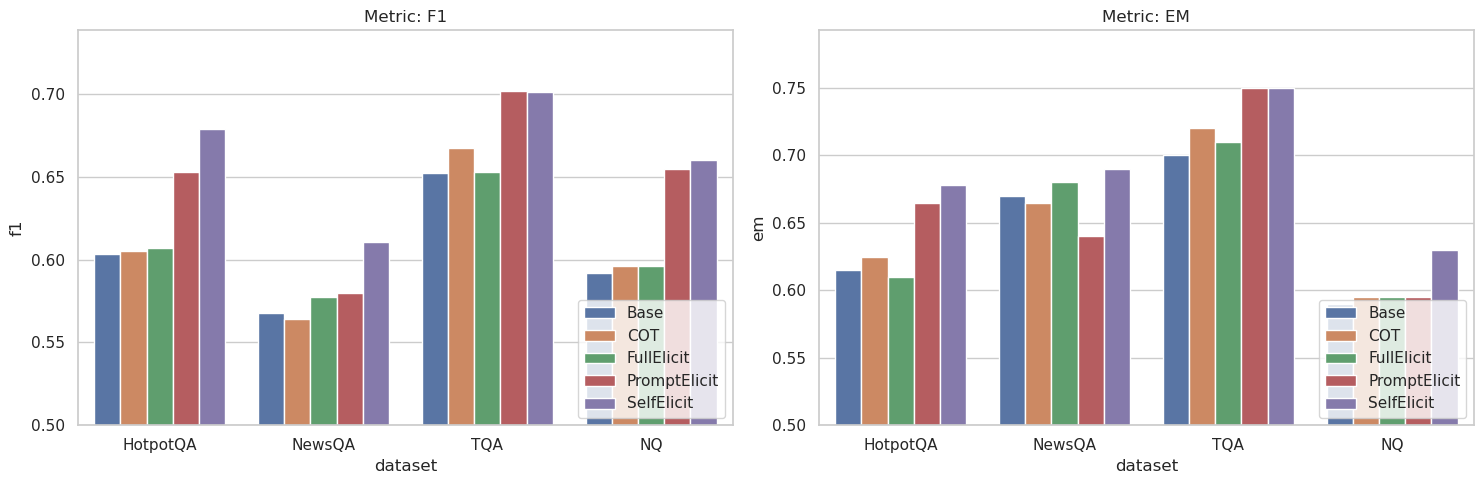

In [4]:
"""
4. Visualize the results
"""

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

metrics = ["f1", "em"]

fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax = sns.barplot(
        x="dataset",
        hue="method",
        y=metric,
        data=qa_results,
        ax=axes[i],
        ci=False,
    )
    ax.legend(loc="lower right")
    ax.set_title(f"Metric: {metric.upper()}")
    ax.set_ylim(0.5, ax.get_ylim()[1])

plt.tight_layout()
plt.show()

## Save results

The results are saved in a CSV file for further analysis.

In [5]:
"""
5. Save the results for future analysis
"""

path = f"results/exp_[MODEL]{args.model_id.replace('/', '|')}_[METHOD]{'-'.join(args.methods)}_[DATA]{'-'.join(args.datasets)}.csv"
print(f"Saving results to {path} ...", end="")
qa_results.to_csv(path, index=False)
print("Success!")

Saving results to results/exp_[MODEL]meta-llama|Meta-Llama-3.1-8B-Instruct_[METHOD]Base-COT-FullElicit-PromptElicit-SelfElicit_[DATA]HotpotQA-NewsQA-TQA-NQ.csv ...Success!
